# Performance Analysis

This notebook used to build the performance analysis of predictors on main and UEP datasets. 

These datasets are the output of "creating_SARS-CoV-2-RBD_ACE2_benchmarking_datasets.ipynb" notebook.

In [8]:
import pathlib
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt 
import json
import os
from scipy import stats
import scipy.stats
import warnings
from collections import Counter
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")

In [9]:
rootdir = pathlib.Path('.').resolve(strict=True)
outputdir = rootdir.parents [1] / 'files/output_files'

In [3]:
# import main and UEP datasets
SARS_CoV_2_RBD_ACE2_benchmarking_dataset = pd.read_csv('SARS-CoV-2-RBD_ACE2_benchmarking_dataset.csv', delimiter=',')
UEP_SARS_CoV_2_RBD_ACE2_benchmarking_dataset = pd.read_csv('UEP_SARS-CoV-2-RBD_ACE2_benchmarking_dataset.csv', delimiter=',')

In [10]:
SARS_CoV_2_RBD_ACE2_benchmarking_dataset

,#case_id,exp_binding,protein,haddock-ddg,foldx-ddg,foldxwater-ddg,evoef1-ddg,mutabind2-ddg,ssipe-ddg,mcsm2-ddg,topnettree-ddg
0,A386C,-0.66,ACE2,2.93,0.00,0.00,-0.04,0.32,0.19,-0.10,NaN
1,A386E,-0.86,ACE2,-1.27,0.16,0.20,0.05,0.25,0.22,0.56,NaN
2,A386I,1.65,ACE2,-3.25,-0.22,-0.26,-0.01,0.28,0.20,0.28,NaN
3,A386L,2.68,ACE2,-1.30,0.12,-0.39,-0.12,0.30,0.16,0.31,NaN
4,A386M,0.32,ACE2,-1.02,-0.06,-0.08,-0.12,0.20,0.16,0.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
258,Y505D,-3.07,RBD,4.03,3.29,3.81,3.08,2.05,2.78,-1.58,0.397130
259,Y505G,-4.65,RBD,3.51,3.45,3.43,3.14,1.11,2.67,-1.56,4.768170
260,Y505M,-2.32,RBD,5.45,2.52,2.54,1.53,0.93,1.38,-1.42,0.173319
261,Y505P,-4.09,RBD,10.26,3.43,3.58,2.73,1.47,3.75,-2.32,1.591504


### Predictor Correlation Heatmap and Line Plot

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'exp_binding'),
  Text(0, 1.5, 'haddock-ddg'),
  Text(0, 2.5, 'foldx-ddg'),
  Text(0, 3.5, 'foldxwater-ddg'),
  Text(0, 4.5, 'evoef1-ddg'),
  Text(0, 5.5, 'mutabind2-ddg'),
  Text(0, 6.5, 'ssipe-ddg'),
  Text(0, 7.5, 'mcsm2-ddg')])

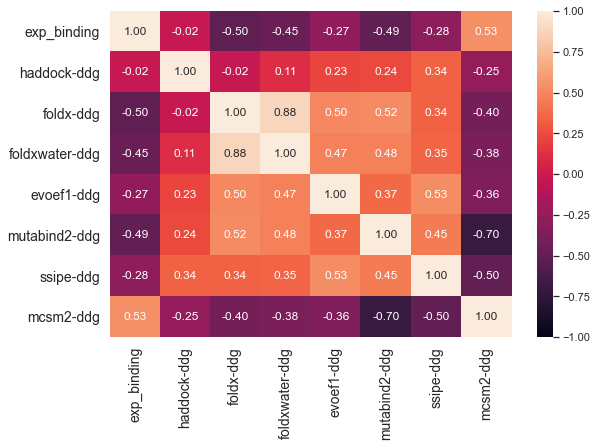

In [11]:
# For all dataset, without TopNetTree
data=SARS_CoV_2_RBD_ACE2_benchmarking_dataset[['exp_binding','haddock-ddg','foldx-ddg','foldxwater-ddg','evoef1-ddg','mutabind2-ddg','ssipe-ddg', "mcsm2-ddg"]].copy()
#print(data)

sns.set(rc = {'figure.figsize':(9,6)})
sns.heatmap(data.corr(),linecolor='black',vmin=-1, vmax=1, annot=True, fmt='.2f')
sns.set(font_scale=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("SIx-Correlation-heatmap.pdf",dpi=300,bbox_inches='tight')
#plt.savefig("SIx-Correlation-heatmap.pdf",dpi=300,bbox_inches='tight', format="pdf")

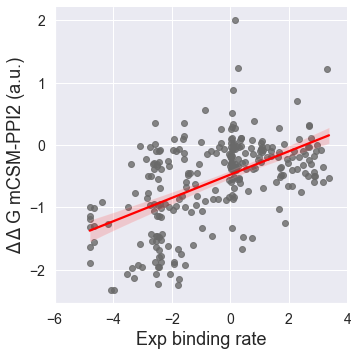

In [12]:
#MCSM-PPI2 predictor vs. experimental correlation
sns.lmplot(x="exp_binding", y="mcsm2-ddg", data=data, scatter_kws={"color": "dimgray"}, line_kws={'color': 'red'});
plt.xlabel('Exp binding rate')
plt.ylabel('\u0394 \u0394 G mCSM-PPI2 (a.u.)')
plt.xlim(xmax=4, xmin=-6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("mcsm2.pdf", format="pdf")

### Binary Classification

In [15]:
def binary_df(df):
    df = df.copy()
    columns= df.columns
    ddg_columns=list(columns[columns.str.contains('ddg')])
    for i in df.iterrows():
        for a in ddg_columns:
            if "mcsm2" in a:
                if i[1][a] < 0:
                    val = 0
                else:
                    val = 1
            else:
                if i[1][a] >= 0:
                    val = 0
                else:
                    val = 1 
            df.loc[i[0], a] = val
        if i[1]["exp_binding"] >= 0:
            val=1
        else:
            val=0
        df.loc[i[0], "exp_binding"] = val
    return df

In [17]:
SARS_CoV_2_RBD_ACE2_binary = binary_df(SARS_CoV_2_RBD_ACE2_benchmarking_dataset.drop(["topnettree-ddg"], axis=1))

In [18]:
SARS_CoV_2_RBD_ACE2_binary

,#case_id,exp_binding,protein,haddock-ddg,foldx-ddg,foldxwater-ddg,evoef1-ddg,mutabind2-ddg,ssipe-ddg,mcsm2-ddg
0,A386C,0.0,ACE2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,A386E,0.0,ACE2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,A386I,1.0,ACE2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,A386L,1.0,ACE2,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,A386M,1.0,ACE2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
258,Y505D,0.0,RBD,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,Y505G,0.0,RBD,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,Y505M,0.0,RBD,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,Y505P,0.0,RBD,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Confussion Matrices

In [19]:
def conf_scores(df):
    
    columns=df.columns
    ddg_columns=columns[columns.str.contains('ddg')]
    
    df_list = list()
    df_list.append(("Total",df.copy()))
    df_list.append(("ACE2", df.loc[df["protein"]=="ACE2"]))
    df_list.append(("RBD", df.loc[df["protein"]=="RBD"]))

    df2 = pd.DataFrame(columns=["Predictor", "True Positive","False Positive", "False Negative","True Negative","Accuracy", "Precision", "Recall", "F1 Score"])
    
    for i in ddg_columns:
        for df in df_list:
            predictor = i.split("-")[0]
            actual = np.array(df[1]["exp_binding"])
            pred = np.array(df[1][i])
            cm = confusion_matrix(actual, pred, labels=[0,1])
            fig = plt.figure()
            sns.heatmap(cm, 
                    annot=True,
                    fmt='g', 
                    xticklabels=["Depleting", "Enrichment"],
                    yticklabels=["Depleting", "Enrichment"])
            plt.ylabel('Actual',fontsize=13)
            plt.xlabel('Prediction',fontsize=13)
            plt.title(f'{predictor} Confusion Matrix {df[0]}',fontsize=17)
            if predictor=="mcsm2":
                plt.savefig(f'figs/{df[0]}_{predictor}_conf_matrix.pdf', dpi=300, format="pdf")

            tn, fp, fn, tp = cm.ravel()
            accuracy = accuracy_score(actual,pred)
            precision = precision_score(actual,pred)
            recall = recall_score(actual,pred)
            F1_score = f1_score(actual,pred)
            ptn = round(100*tn/(tn+fn), 2)
            pfn = round(100*fn/(tn+fn), 2)
            ptp = round(100*tp/(tp+fp), 2)
            pfp = round(100*fp/(tp+fp), 2)
            df2.loc[len(df2.index)] = [f"{predictor}_{df[0]}", tp, fp, fn, tn, accuracy, precision, recall, F1_score]
    return df2

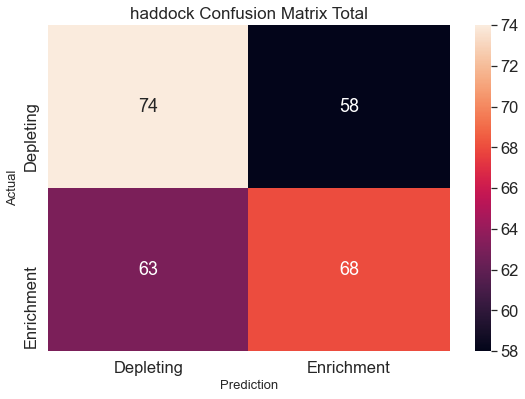

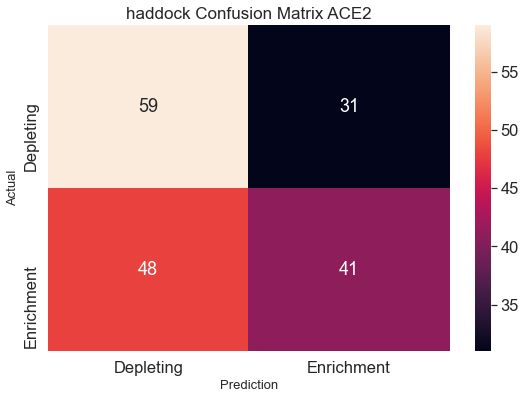

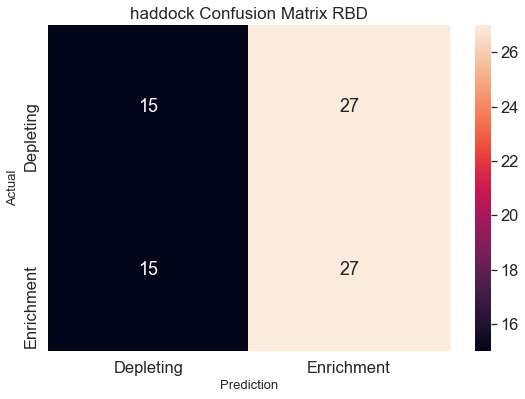

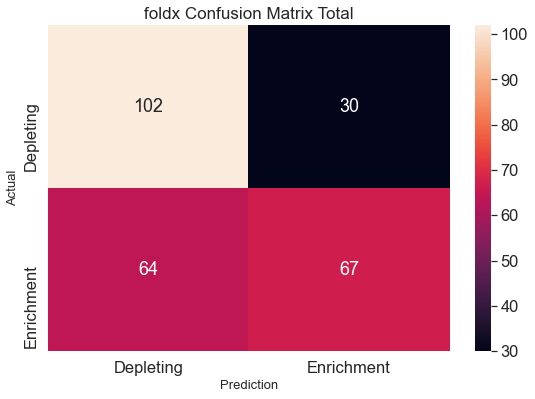

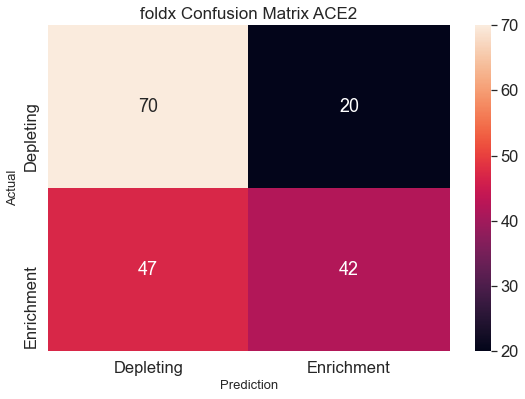

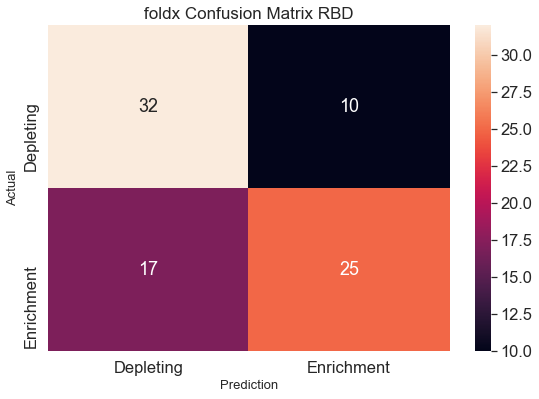

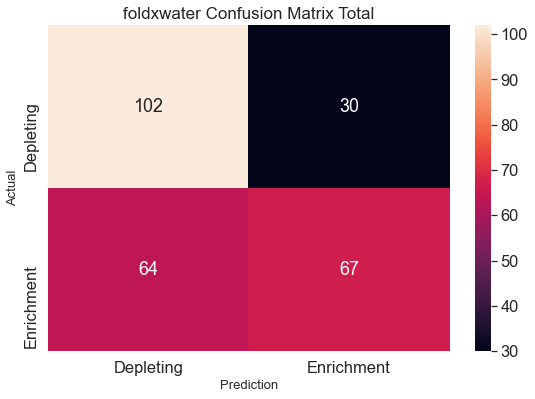

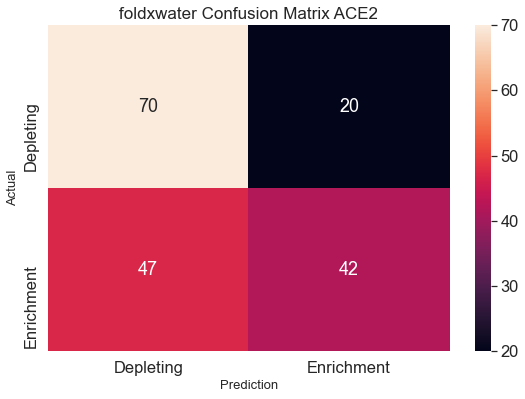

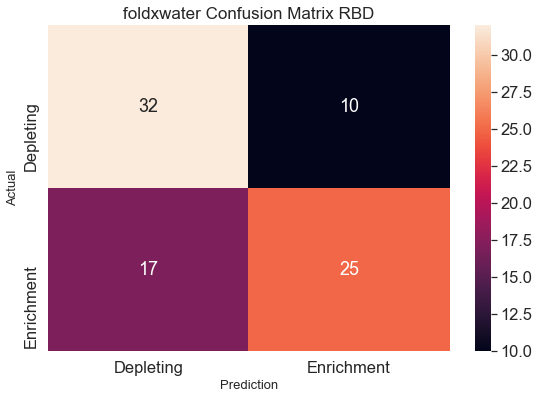

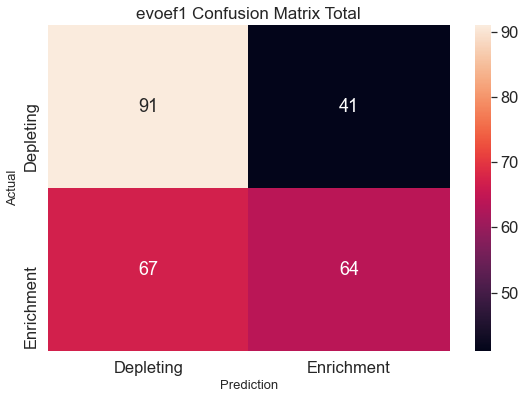

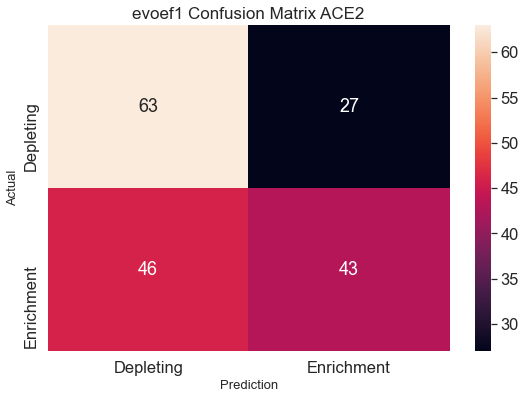

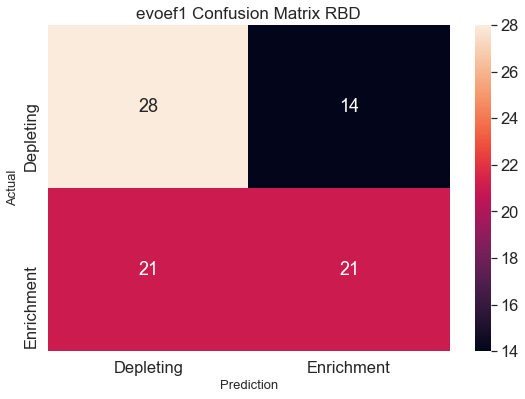

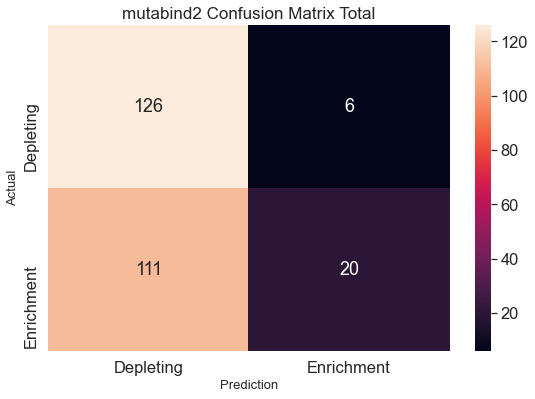

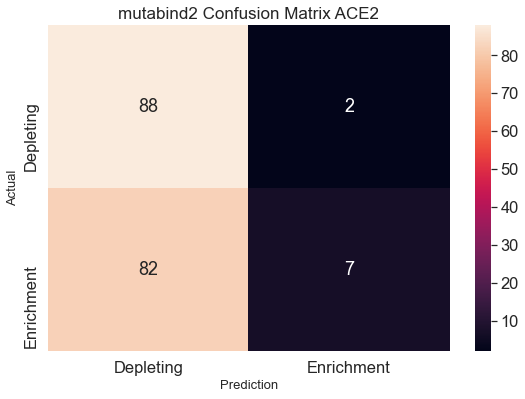

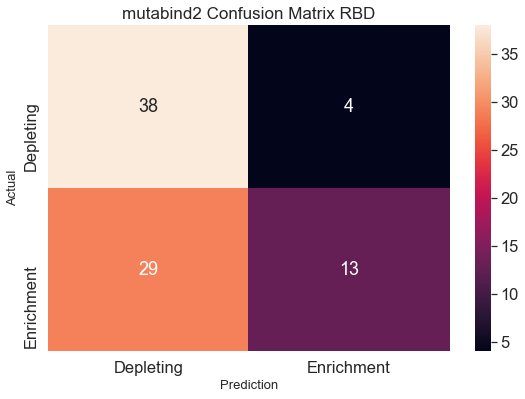

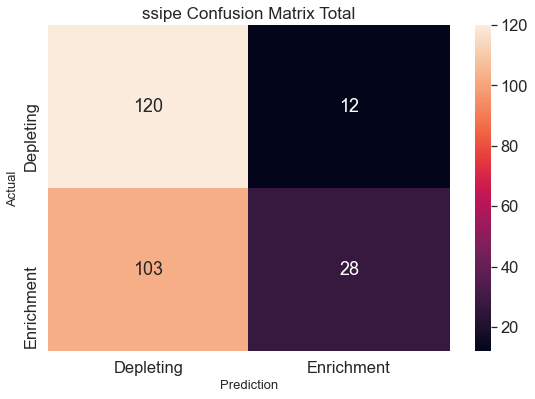

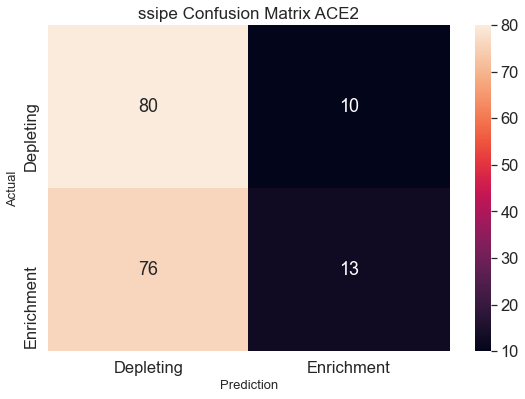

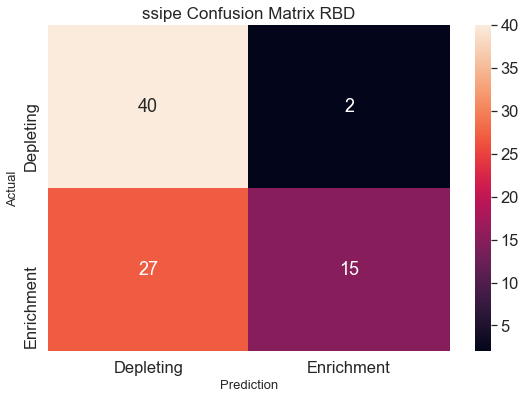

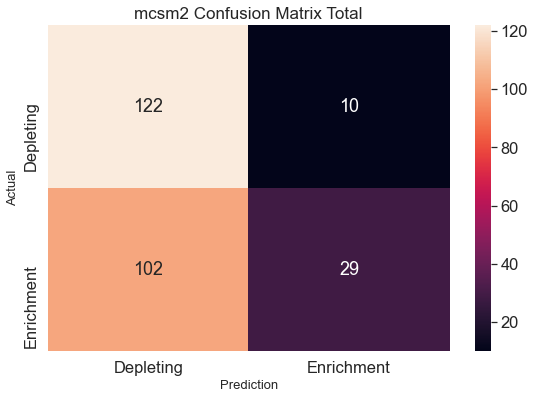

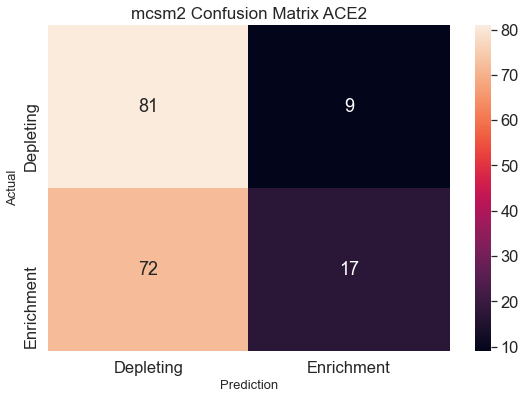

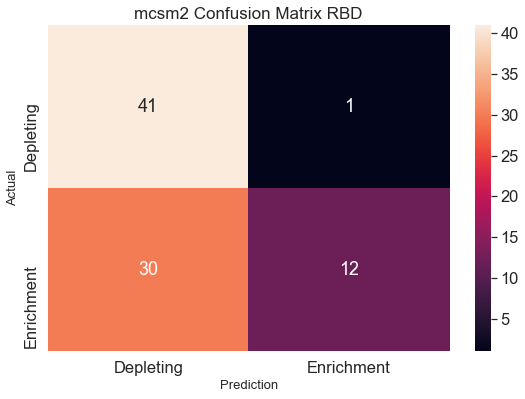

In [20]:
SARS_CoV_2_RBD_ACE2_metrics = conf_scores(SARS_CoV_2_RBD_ACE2_binary)

In [21]:
SARS_CoV_2_RBD_ACE2_metrics

,Predictor,True Positive,False Positive,False Negative,True Negative,Accuracy,Precision,Recall,F1 Score
0,haddock_Total,68,58,63,74,0.539924,0.539683,0.519084,0.529183
1,haddock_ACE2,41,31,48,59,0.558659,0.569444,0.460674,0.509317
2,haddock_RBD,27,27,15,15,0.500000,0.500000,0.642857,0.562500
3,foldx_Total,67,30,64,102,0.642586,0.690722,0.511450,0.587719
4,foldx_ACE2,42,20,47,70,0.625698,0.677419,0.471910,0.556291
5,foldx_RBD,25,10,17,32,0.678571,0.714286,0.595238,0.649351
6,foldxwater_Total,67,30,64,102,0.642586,0.690722,0.511450,0.587719
7,foldxwater_ACE2,42,20,47,70,0.625698,0.677419,0.471910,0.556291
8,foldxwater_RBD,25,10,17,32,0.678571,0.714286,0.595238,0.649351
9,evoef1_Total,64,41,67,91,0.589354,0.609524,0.488550,0.542373


In [22]:
SARS_CoV_2_RBD_ACE2_metrics.to_csv("SARS_CoV_2_RBD_ACE2_metrics.csv", index=False)

## Seperation of Mutations According to the Confussion Matirx

In [26]:
def get_muts(df):
    df = df.copy()
    columns=df.columns
    ddg_columns=columns[columns.str.contains('ddg')]
    fn_dict = dict()
    tn_dict = dict()
    fp_dict = dict()
    tp_dict = dict()
    dicts = [(fn_dict, 1,0), (tn_dict, 0,0), (fp_dict, 0,1), (tp_dict, 1,1)]
    for i in df.iterrows():
        r = i[1]
        #print(r)
        for j in ddg_columns:
            for tup in dicts:
                tgt_dict = tup[0]
                exp_cond = tup[1]
                pred_cond = tup[2]
                if j not in tgt_dict.keys():
                    tgt_dict[j] = {"ACE2":list(), "RBD":list()}
                if r["exp_binding"] == exp_cond and r[j] == pred_cond:
                    tgt_dict[j][r["protein"]].append(r["#case_id"])
    return fn_dict, tn_dict, fp_dict, tp_dict

In [27]:
fns, tns, fps, tps = get_muts(SARS_CoV_2_RBD_ACE2_binary)

In [28]:
with open('false_negatives.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(fns))
with open('true_negatives.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(tns))
with open('false_positives.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(fps))
with open('true_positives.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(tps))

## Consurf analyze

In [10]:
def get_consurf(df):
    df = df.copy()
    df["consurf_score"] = np.nan

    files = [("ACE2", "Consurf_Outputs_ACE2/consurf.grades"), ("RBD", "Consurf_Outputs_RBD/consurf.grades")]
    for ff in files:
        with open(ff[1], "r") as file:
            for f in file:
                row = f.strip(" ")
                row = row.split("\t")
                if row[0].isnumeric():
                    one_letter = row[1].lstrip(" ")
                    num = row[2].lstrip(" ").split(":")[0][3:]
                    score = row[5].lstrip(" ").rstrip("*")
                    name = one_letter+num
                    for index, i in df.loc[df["protein"]==ff[0]].iterrows():
                        if name in i["#case_id"]:
                            df.iloc[index, df.columns.get_loc("consurf_score")] = score
                            
    return df

In [11]:
cons_df = get_consurf(SARS_CoV_2_RBD_ACE2_binary)

In [13]:
with open("true_positives.txt", "r") as f:
    tps = json.load(f)
with open("true_negatives.txt", "r") as f:
    tns = json.load(f)
with open("false_positives.txt", "r") as f:
    fps = json.load(f)
with open("false_negatives.txt", "r") as f:
    fns = json.load(f)

In [14]:
def get_scores(l, protein):
    nl = list()
    for i in l:
        score = cons_df.loc[(cons_df["#case_id"]==i)&(cons_df["protein"]==protein)]["consurf_score"].values[0]
        nl.append(int(score))
    return nl

In [15]:
cons_dict = dict()
for pred,proteins in tps.items():
    cons_dict[pred] = dict()
    for protein, muts in proteins.items():
        cons_dict[pred][protein] = dict()
        cons_dict[pred][protein]["True Positive"] = get_scores(muts, protein)
        cons_dict[pred][protein]["True Negative"] = get_scores(tns[pred][protein],protein)
        cons_dict[pred][protein]["False Positive"] = get_scores(fps[pred][protein],protein)
        cons_dict[pred][protein]["False Negative"] = get_scores(fns[pred][protein],protein)

In [16]:
cs = [x for x in range(1,10)]
for pred, data in cons_dict.items():
    for i, prot in enumerate(data.keys()):
        for st, x in data[prot].items():
            data[prot][st] = [(i, x.count(i)) for i in np.unique(x)]

In [54]:
plot_dict = dict()
keys = [x for x in range(1,10)]
for pred, data in cons_dict.items():
    plot_dict[pred] = dict()
    for prot, data2 in data.items():
        plot_dict[pred][prot] = dict.fromkeys(keys)
        for s,v in plot_dict[pred][prot].items():
            plot_dict[pred][prot][s] = [0,0,0,0]
        for index, (stat, data3) in enumerate(data2.items()):
            for (key,val) in data3:
                plot_dict[pred][prot][key][index] = val

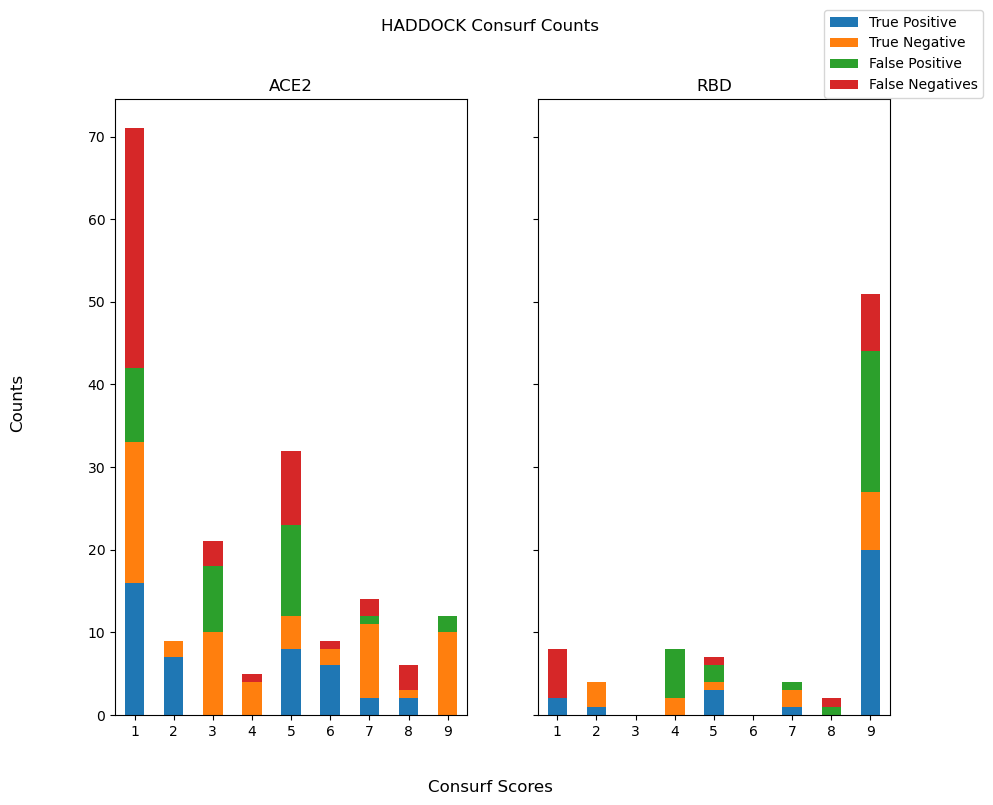

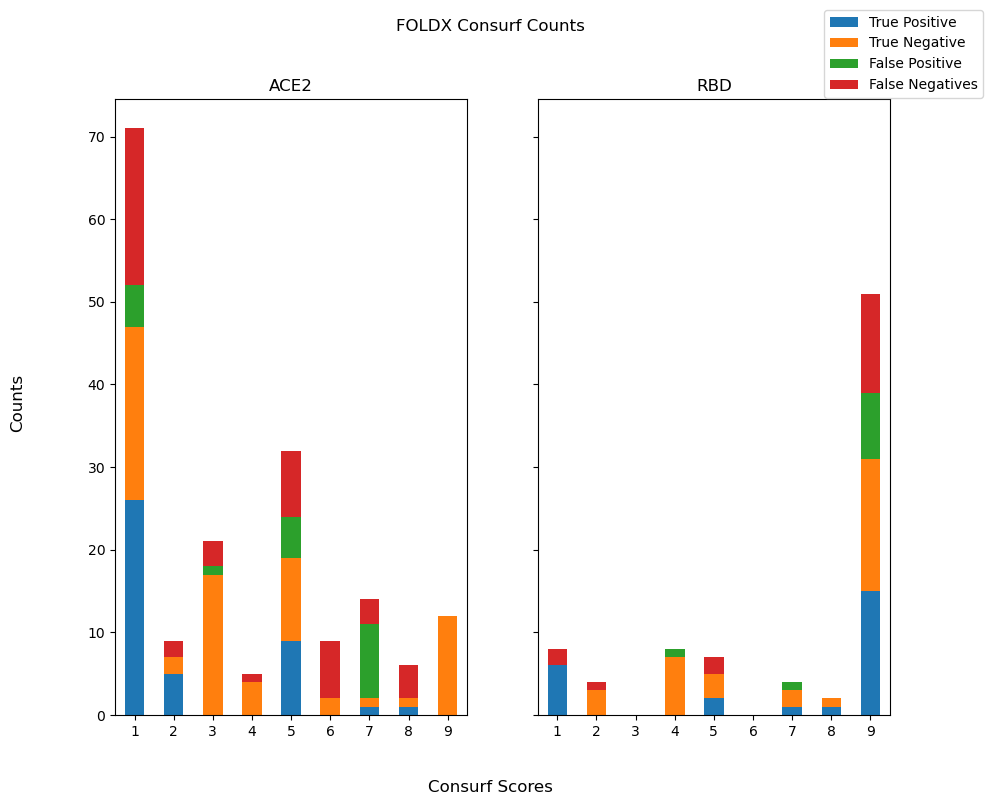

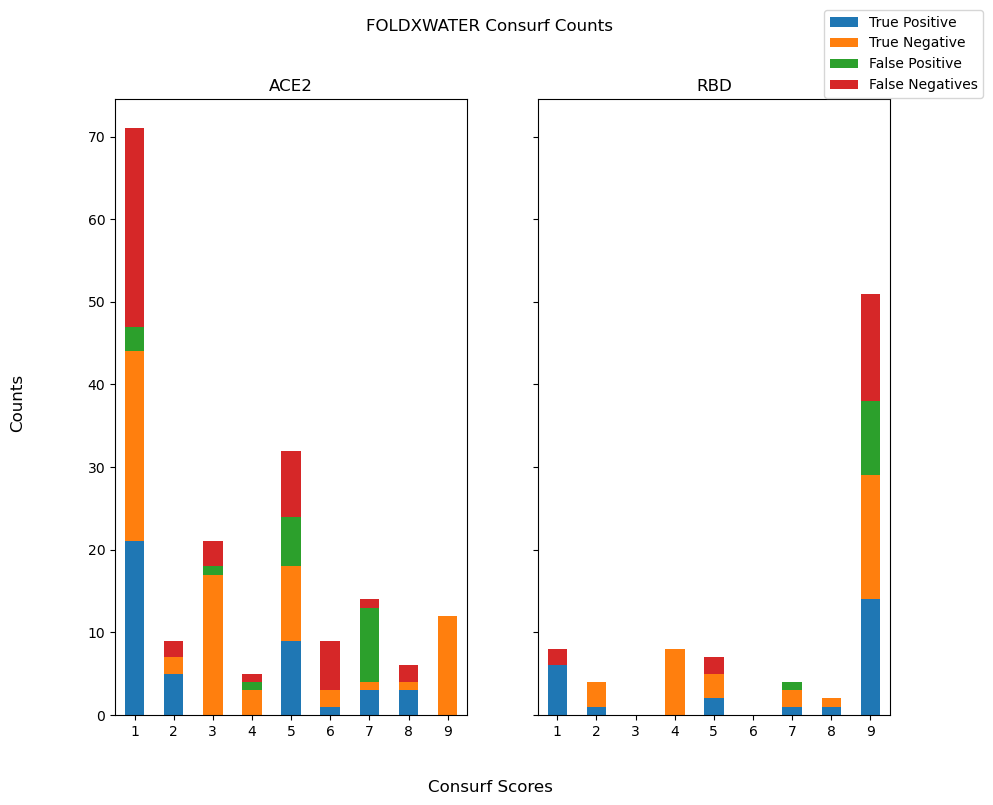

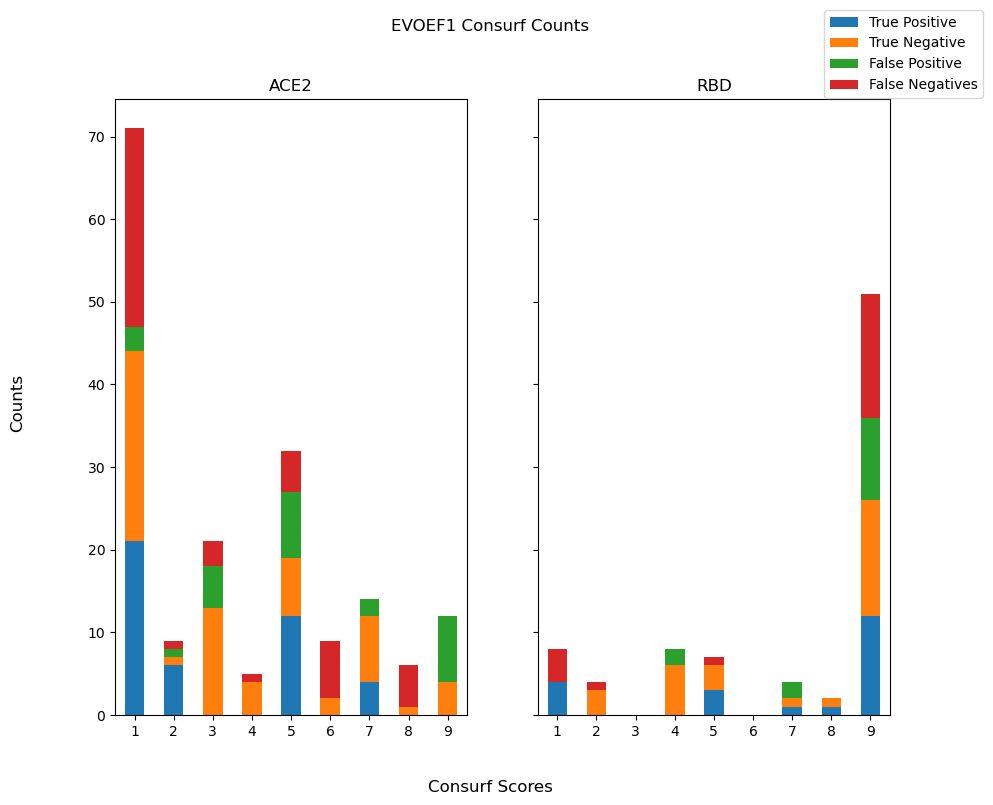

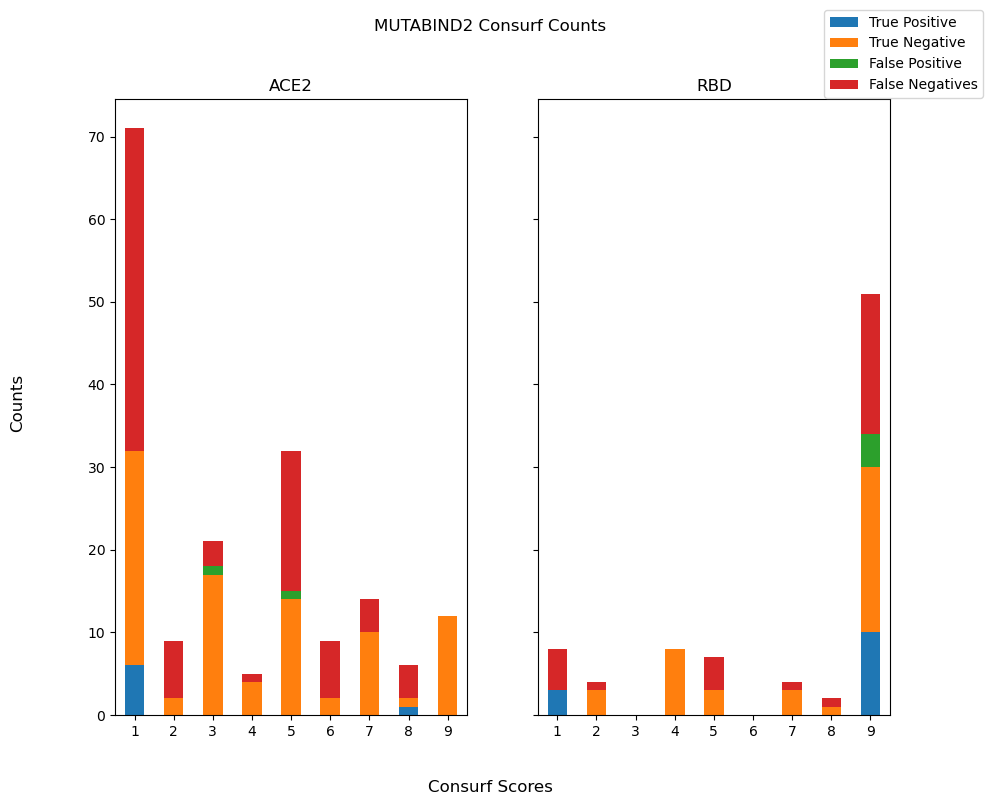

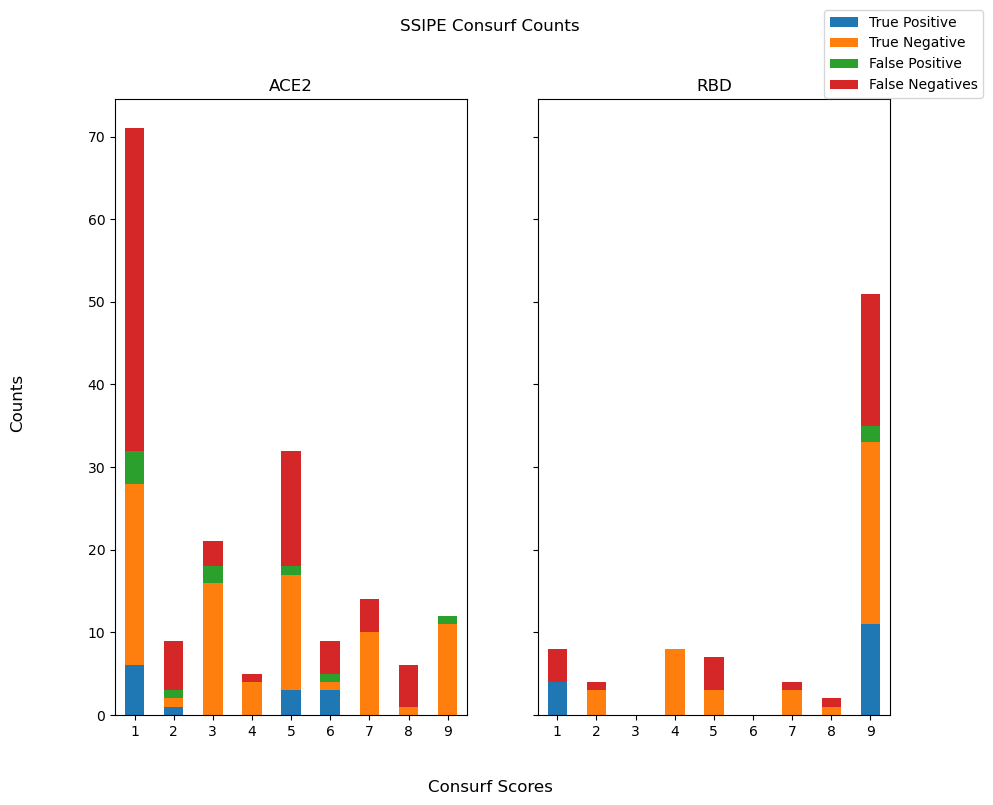

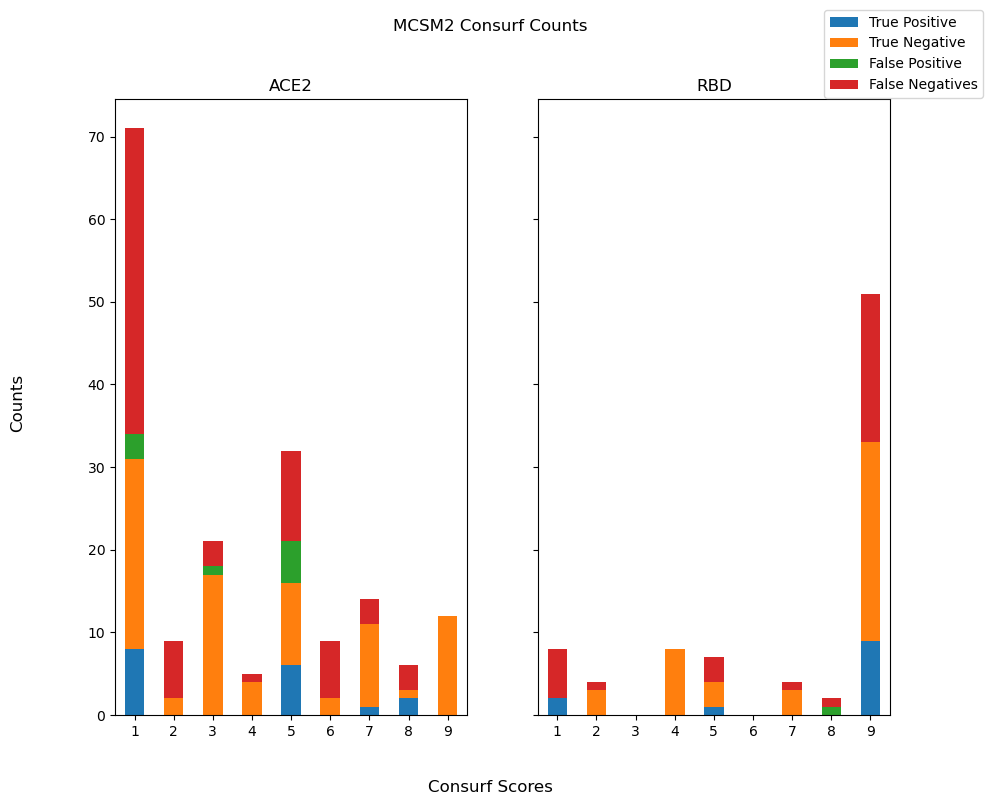

In [107]:

for pred, data in plot_dict.items():
    fig, ax = plt.subplots(1,2, figsize=(10,8), sharey=True, sharex=True)
    for index, (prot,data2) in enumerate(data.items()):
        df = pd.DataFrame(data2)
        df.T.plot(kind="bar", stacked=True, ax=ax[index])
        ax[index].set_title(f"{prot}")
        ax[index].get_legend().remove()
        ax[index].set_xticklabels(range(1,10), rotation="horizontal")
        
    
    fig.suptitle(f"{pred.split('-')[0].upper()} Consurf Counts")
    fig.supxlabel("Consurf Scores")
    fig.supylabel("Counts")
        
    fig.legend(labels=["True Positive", "True Negative", "False Positive", "False Negatives"], bbox_to_anchor=(1,1))

    plt.savefig(f"figs/cons_figs/{pred.split('-')[0].upper()}_cons_counts.png", dpi=300)

### TopNetTree Performance

In [38]:
a = SARS_CoV_2_RBD_ACE2_benchmarking_dataset[SARS_CoV_2_RBD_ACE2_benchmarking_dataset["protein"]=="RBD"]

In [12]:
data=a[['exp_binding','haddock-ddg','foldx-ddg','foldxwater-ddg','evoef1-ddg','mutabind2-ddg','ssipe-ddg', "mcsm2-ddg", "topnettree-ddg"]].copy()

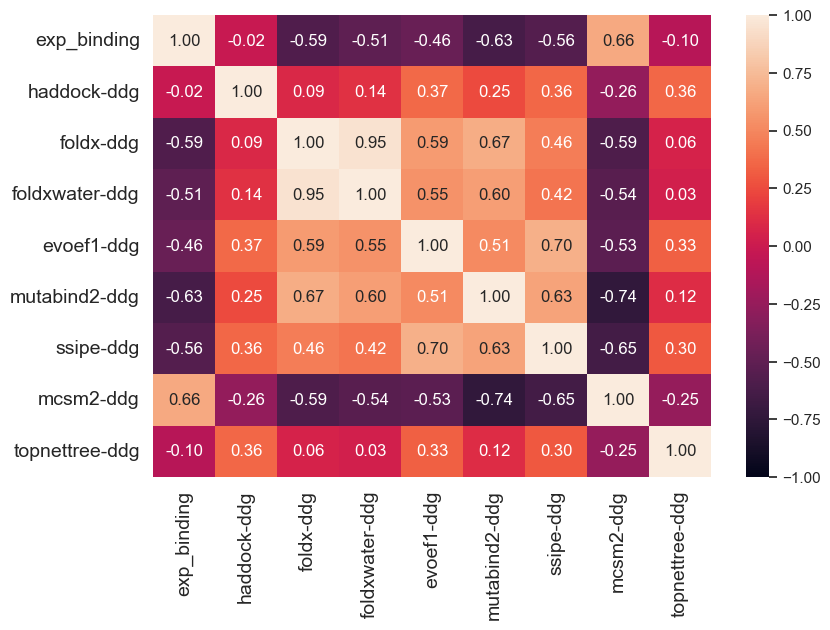

In [13]:
# Predictor Correlation with RBD dataset
sns.set(rc = {'figure.figsize':(9,6)})
sns.heatmap(data.corr(),linecolor='black',vmin=-1, vmax=1, annot=True, fmt='.2f')
sns.set(font_scale=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("SIx-Correlation-heatmap-RBD.pdf",dpi=300,bbox_inches='tight', format="pdf")

-0.0951366802644803 0.38933067103400204


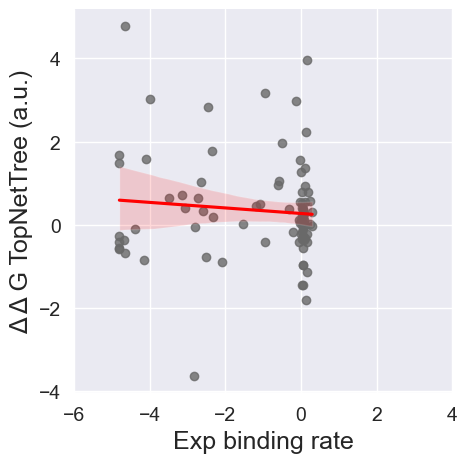

In [15]:
# TopNetTree predictor vs. experimental correlation
data2 = data.reset_index()

sns.lmplot(x="exp_binding", y="topnettree-ddg", data=data2, scatter_kws={"color": "dimgray"}, line_kws={'color': 'red'});
plt.xlabel('Exp binding rate')
plt.ylabel('\u0394 \u0394 G TopNetTree (a.u.)')
plt.xlim(xmax=4, xmin=-6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("tnt_corr.pdf",dpi=300,bbox_inches='tight', format="pdf")

[r, p] = scipy.stats.pearsonr(data['exp_binding'], data['topnettree-ddg'])
print(r,p)

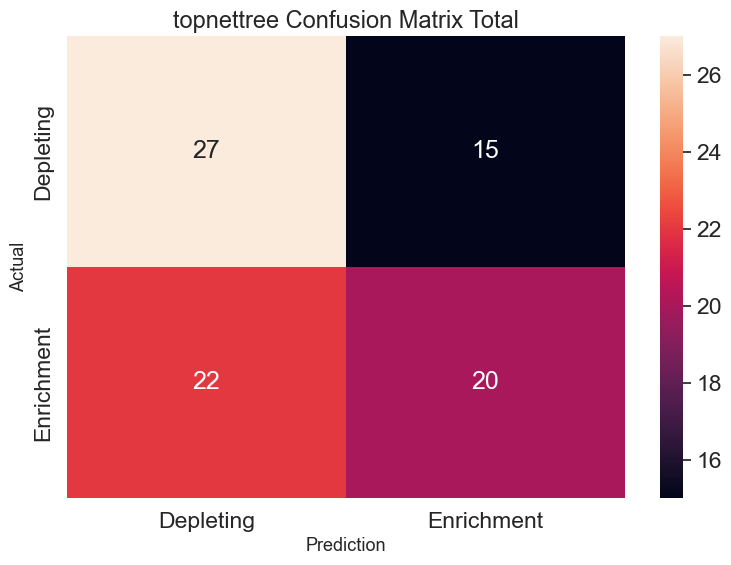

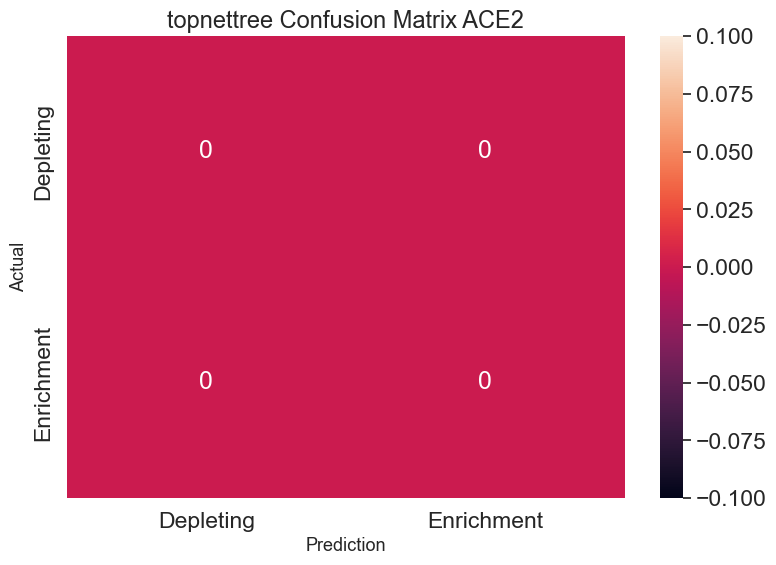

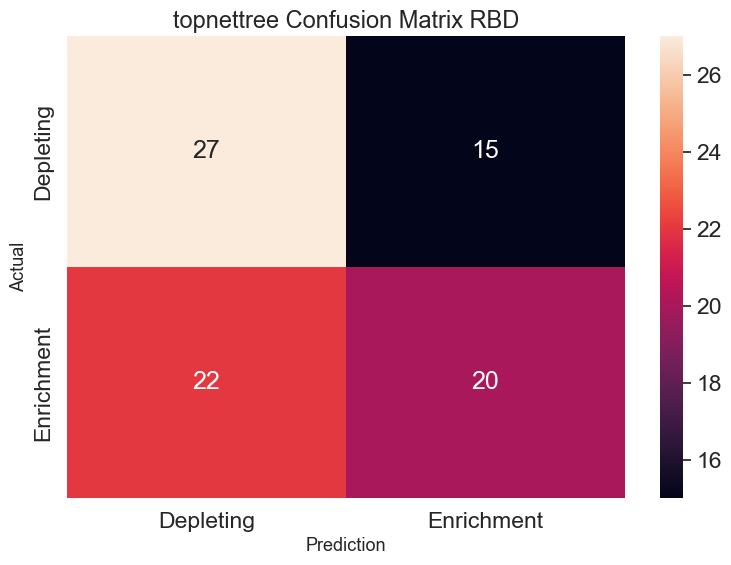

In [39]:
df = a[["#case_id", "topnettree-ddg", "exp_binding"]]

tnt_binary = binary_df(df)

tnt_binary["protein"]=["RBD" for i in range(0,len(tnt_binary))]
val = [float(i) for i in tnt_binary["exp_binding"].values]
val2 = [float(i) for i in tnt_binary["topnettree-ddg"].values]
tnt_binary["exp_binding"] = val
tnt_binary["topnettree-ddg"] = val2

tnt_binary = tnt_binary[["#case_id", "exp_binding", "protein", "topnettree-ddg"]]

tnt_metrices = conf_scores(tnt_binary)
plt.savefig("tnt_conf_matrix.pdf", dpi=300)

In [40]:
tnt_metrices

,Predictor,True Positive,False Positive,False Negative,True Negative,Accuracy,Precision,Recall,F1 Score
0,topnettree_Total,20,15,22,27,0.559524,0.571429,0.47619,0.519481
1,topnettree_ACE2,0,0,0,0,NaN,0.000000,0.00000,0.000000
2,topnettree_RBD,20,15,22,27,0.559524,0.571429,0.47619,0.519481


In [53]:
metrics2 = SARS_CoV_2_RBD_ACE2_metrics.copy()

for i in range(3):
    metrics2.loc[len(metrics2.index)] = tnt_metrices.loc[i]

In [54]:
metrics2

,Predictor,True Positive,False Positive,False Negative,True Negative,Accuracy,Precision,Recall,F1 Score
0,haddock_Total,68,58,63,74,0.539924,0.539683,0.519084,0.529183
1,haddock_ACE2,41,31,48,59,0.558659,0.569444,0.460674,0.509317
2,haddock_RBD,27,27,15,15,0.500000,0.500000,0.642857,0.562500
3,foldx_Total,67,30,64,102,0.642586,0.690722,0.511450,0.587719
4,foldx_ACE2,42,20,47,70,0.625698,0.677419,0.471910,0.556291
5,foldx_RBD,25,10,17,32,0.678571,0.714286,0.595238,0.649351
6,foldxwater_Total,67,30,64,102,0.642586,0.690722,0.511450,0.587719
7,foldxwater_ACE2,42,20,47,70,0.625698,0.677419,0.471910,0.556291
8,foldxwater_RBD,25,10,17,32,0.678571,0.714286,0.595238,0.649351
9,evoef1_Total,64,41,67,91,0.589354,0.609524,0.488550,0.542373


### general performance

In [80]:
last_df = pd.DataFrame(columns=[ 'Predictor','Total', 'Enriched', 'Depleted', 'ACE2', 'ACE2 Enriched', 'ACE2 Depleted', 'RBD', 'RBD Enriched', 'RBD Depleted'])
pred_in = ''
for idx, row in metrics2.iterrows():
    pred = row['Predictor'].split('_')[0]
    if idx == 0:
        pred_in = pred
        nrow = []
        nrow.append(pred.upper())
    if idx != 0 and pred != pred_in and idx%3 == 0:
        last_df.loc[len(last_df)] = nrow
        nrow=[]
        nrow.append(pred.upper())
    try:
        total = (row[1]+row[4])/(sum(row[1:5]))
        enriched = row[1]/(row[1] + row[3])
        depleted = row[4]/(row[4] + row[2])
    except ZeroDivisionError:
        total=None
        enriched=None
        depleted=None
    finally:
        nrow.append(total)
        nrow.append(enriched)
        nrow.append(depleted)    
last_df.loc[len(last_df)] = nrow

In [81]:
last_df

,Predictor,Total,Enriched,Depleted,ACE2,ACE2 Enriched,ACE2 Depleted,RBD,RBD Enriched,RBD Depleted
0,HADDOCK,0.539924,0.519084,0.560606,0.558659,0.460674,0.655556,0.500000,0.642857,0.357143
1,FOLDX,0.642586,0.511450,0.772727,0.625698,0.471910,0.777778,0.678571,0.595238,0.761905
2,FOLDXWATER,0.642586,0.511450,0.772727,0.625698,0.471910,0.777778,0.678571,0.595238,0.761905
3,EVOEF1,0.589354,0.488550,0.689394,0.592179,0.483146,0.700000,0.583333,0.500000,0.666667
4,MUTABIND2,0.555133,0.152672,0.954545,0.530726,0.078652,0.977778,0.607143,0.309524,0.904762
5,SSIPE,0.562738,0.213740,0.909091,0.519553,0.146067,0.888889,0.654762,0.357143,0.952381
6,MCSM2,0.574144,0.221374,0.924242,0.547486,0.191011,0.900000,0.630952,0.285714,0.976190
7,TOPNETTREE,0.559524,0.476190,0.642857,NaN,NaN,NaN,0.559524,0.476190,0.642857
